# CSCI E-25      
## Filtering Images  
### Steve Elston

## Introduction    

Preprocessing of images is generally an essential step in most computer vision applications. Preprocessing typically involves filtering of one type or another which is out focus here. Here we will focus on two types of filters.    
1. Filters for noise elimination and edge detection.    
2. Morphology filters.     

To get started execute the code in the cell below to import the packages you will need. 

In [2]:
import skimage 
from skimage import data
from skimage.filters.rank import equalize
import skimage.filters as skfilters
import skimage.morphology as morphology
import skimage.transform as transform
from skimage.color import rgb2gray
from skimage import exposure
from skimage.transform import pyramid_gaussian
import numpy as np
from scipy import fft
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Prepare Image

For the exercises you will work with a complex image of a striped cat. Execute the code in the cell below to load and display the image.  

Image size = (300, 451, 3)


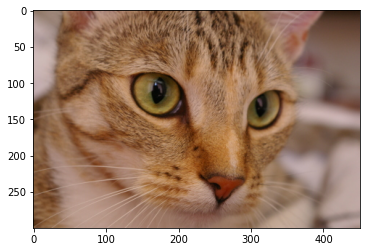

In [3]:
cat_image = data.cat()
print('Image size = ' + str(cat_image.shape))
_=plt.imshow(cat_image)

This image is complex. The image shows typical typical facial features of a cat, eyes, nose, whiskers, etc. The cat's face also has a complex pattern of strips and patches if different colors. Additionally, there are complex features in the background, including the cat's chest patch, part of an ear and blurred patches that appear to include the cat's flank. Preparing such a complex image for further processing can be quite challenging.      

> **Exercise 2-1:** You will now prepare the cat image for further processing by the following steps:   
> 1. Convert the 3-channel color image to gray-scale. 
> 2. Display the gray-scale image along with the distribution of pixel values using the functions provided.  
> 3. Apply adaptive histogram equalization to the gray-scale image. Name the resulting image `cat_grayscale_equalized`. 
> 4. Display the equalized gray-scale image along with the distribution of pixel values using the functions provided.  

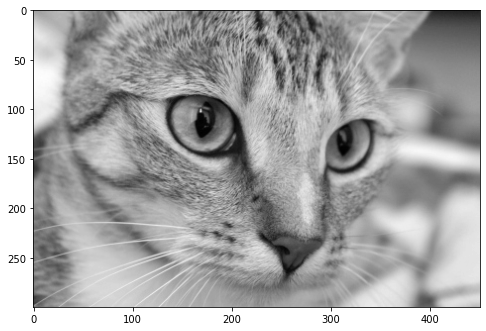

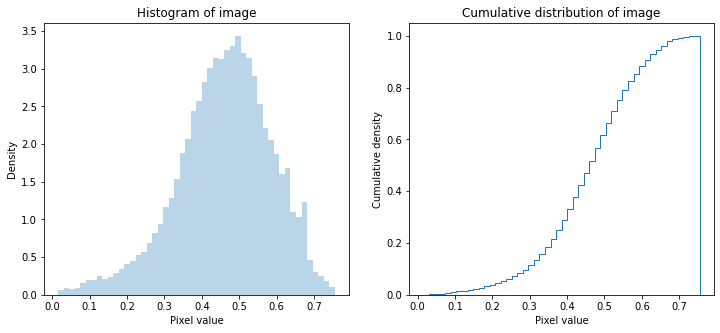

In [4]:
def plot_grayscale(img, h=8):
    plt.figure(figsize=(h, h))
    _=plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()
    
def plot_gray_scale_distribution(img):
    '''Function plots histograms a gray scale image along 
    with the cumulative distribution'''
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].hist(img.flatten(), bins=50, density=True, alpha=0.3)
    ax[0].set_title('Histogram of image')
    ax[0].set_xlabel('Pixel value')
    ax[0].set_ylabel('Density')
    ax[1].hist(img.flatten(), bins=50, density=True, cumulative=True, histtype='step')
    ax[1].set_title('Cumulative distribution of image')  
    ax[1].set_xlabel('Pixel value')
    ax[1].set_ylabel('Cumulative density')  
    plt.show()

cat_grayscale = rgb2gray(cat_image)
plot_grayscale(cat_grayscale)
plot_gray_scale_distribution(cat_grayscale)

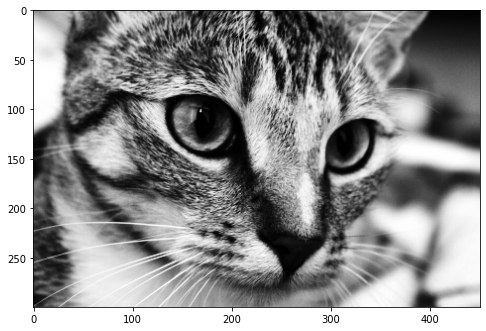

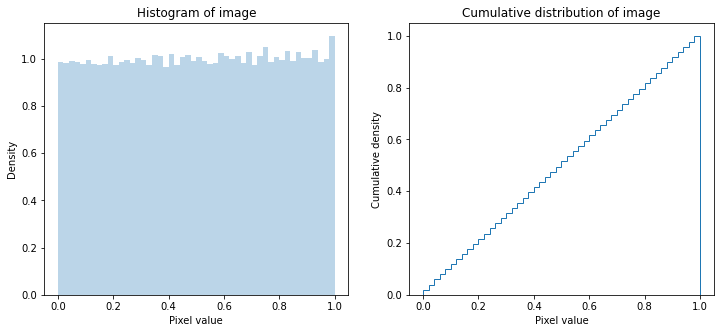

In [5]:
cat_grayscale_equalized = exposure.equalize_hist(cat_grayscale.flatten()).reshape(cat_grayscale.shape)
plot_grayscale(cat_grayscale_equalized)
plot_gray_scale_distribution(cat_grayscale_equalized)  

> Answer the following questions:   
> 1. How has the adaptive histogram equalization changed the image and is this change an improvement from a computer vision point of view?  
> 2. How has the adaptive histogram equalization changed the distribution of pixel values? 
> **End of exercise.** 

> **Answers:**
> 1. The adaptive histogram equalization has increased the contrast in the image and this is a positive improvement from a computer vision point of view because it accentuates the features in the image by increasing the variance in the pixel values.
> 2. It has changed the distribution of pixel values from a roughly gaussian distribution centered around 5 and ranging from 0 to 0.5, to a uniform distribution ranging from 0 to 1.

> **Important note!:** For subsequent exercises, your starting point should always be the `cat_grayscale_equalized` image just created. This is in keeping with good practice of starting with a properly adjusted image before applying any CV algorithms. 

Another way to understand the effect of a filter on the image is to examine the power spectrum of the image. Specifically, we will use the [scipy.fft.fft2]https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft2.html#scipy.fft.fft2) function which performs a d-dimensional [fast Fourier transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform) on the real-valued image. The zero frequency components of the FFT are shifted to the center of the array using the [scipy.fft.fftshift](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftshift.html#scipy.fft.fftshift) function. 

The function in the cell below computes the FFT of two images. The results of the FFT calculation are complex numbers, amplitude and phase. A 2-dimensional array of complex numbers is hard to display, so we will use the magnitude of the complex number, using the [numpy.absolute](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html) function. The values are then squared to units of power using the [numpy.square](https://numpy.org/doc/stable/reference/generated/numpy.square.html) function. 

These values can range over several orders of magnitude so we use a logarithmic color scale for the image display. 

To see the difference in the frequency components of the original image and the equalized image, execute the code in the cell below. 

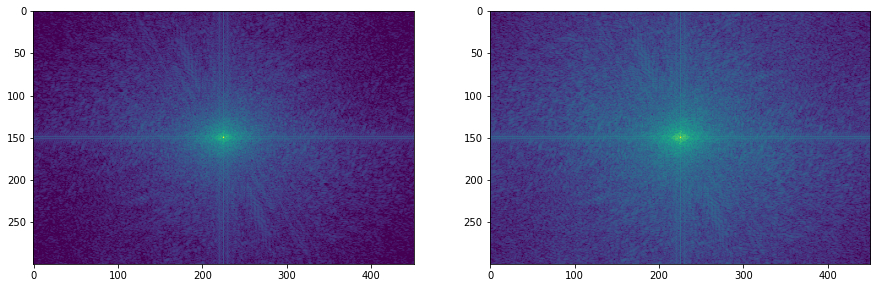

In [6]:
image_power = lambda x: np.square(np.abs(fft.fftshift(fft.fft2(x))))

def plot_2d_fft(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    im = ax[0].imshow(image_power(img1), norm=LogNorm(vmin=5))    
    im = ax[1].imshow(image_power(img2), norm=LogNorm(vmin=5))        
    plt.show()
    plt.show()
    
plot_2d_fft(cat_grayscale, cat_grayscale_equalized)     

The interpretation of the 2-dimensional power spectrum plot requires some explanation. The plot shows both vertical and horizontal frequency components. The Fourier transform values can be positive and negative, and symmetric for the real-valued image. The square of the absolute value of these components are the same. Therefore the values in the four quadrants of the plot will be identical.        

The zero frequency (constant) component of the image are is at the center. There zero vertical frequency components can be seen as a centered horizontal line and the zero horizontal frequency components can be seen as a vertical line. These lines divide the four identical quadrants of the plot. 

The further from the center a component is the higher the frequency. The maximum (at the Nyquist rate) vertical and horizontal frequency component is in the corner of the plot. Intermediate frequencies are between the center and the corner.

Compare these displays. First, notice that much of the power (energy) in the image is at or near 0 frequency, indicating that the values across the image are mostly constant. Second, you can see that equalization has amplified the higher frequency components for both dimensions of the image.  

### 1.1 Convolution in 1 dimension

To get started, let's work with the simplest case of one dimensional convolution. Convolution is a process of applying a filter of a certain span over one of more dimensions of the data. 

To conceptually understand 1-d convolution examine Figure 1.1 below.. At each time step a value for output series is computed by applying the convolution operator to the input series. The convolution operator is a set of weights $\{ W_1, W_2, W_3 \}$ which are mutilied by the input values. The weighted inputs are then summed to compute the value of the output series. The operator is then moved along the input series (by the stride of 1 in this case). The procecss proceeds until the end of the series is reached. 

Notice that the output series is shorter than the input series by $\frac{Span + 1}{2}$. In the illustrated example the kernel has a span of 3, makig the output series length by 2. This reduction in the length of the output is inherent in all convolution operations. 

![](img/ParameterSharing.JPG)
<center>**Figure 1.1. 1-d convolution with operator span of 3**</center> 

Mathematically, we write the convolution operation:

$$s(t) = (x * k)(t) = \sum_{\tau = -\infty}^{\infty} x(t) k(t - \tau)$$
where,   
$s(t)$ is the output of the convolution operation at time $t$,  
$x$ is the series of values,  
$k$ is the convolution kernel,  
$*$ is the convolution operator,  
$\tau$ is the time difference of the convolution operator.  


Summing over the range $\{-\infty, \infty \}$ seems to be a problem. However, in practice the convolutional kernal has a finite span, $s$. For an operator with an odd numbered span, we can then rewrite the above equation as:

$$s(t) = (x * k)(t) = \sum_{\tau = {t - a}}^{t + a} x(t) k(t - \tau)$$    

Where, $a = \frac{1}{2}(kernel\_span + 1)$, for an odd length kernel. 

In other words, we only need to take the sum over the span of the convolution operator. Notice that this operator is non-causal, since values from ahead of the time step being operated on are used to compute the output. 

> **Exercise 2-2:** To make this all a bit more concrete, you will try a code example. You will construct a short filter and apply it over a 1-d series. In the cell below you will implement a simple 1-d convolution operation given a set of kernel weights. The core of this operation is a dot product between the subset of values of the series and the kernel weights. You will first use a 3-point moving average kernel, $[0.333, 0.333, 0.333]$. Do the following: 
> 1. Create a function that performs convolution of the moving average kernel with the random series. You can perform this operation by iteratively calling [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) as you move the operator along the 3-point segments of the series. Your function should have two arguments, the series and the kernel. the Make sure you account for the fact that for this operator with span of 3 (an odd number) the length of the result will be 2 points shorter than the original series, one point shorter on each end.    
> 2. Use the code provided to create a step-function series with random noise added. 
> 3. Execute your function and plot the result using the function provided.  
> 4. Finally, execute your function and plot the result using a 5-point Gaussian kernel $[0.05, 0.242, 0.399, 0.242, 0.05]$.

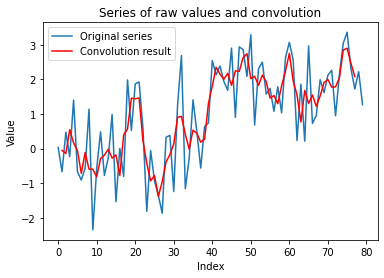

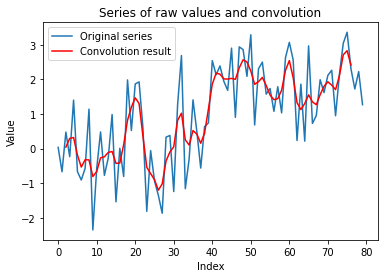

In [27]:
def plot_conv(series, conv, span):
    x = list(range(series.shape[0]))
    offset = int((span-1)/2)
    end = series.shape[0] - offset
    plt.plot(x, series, label = 'Original series')
    plt.plot(x[offset:end], conv, color = 'red', label = 'Convolution result')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Series of raw values and convolution')
    plt.show()

np.random.seed(12233)
series = np.concatenate((np.random.normal(size = 40), np.random.normal(size = 40) + 2.0))  


def convolve(series: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    convolution = []
    for i in range(series.size - kernel.size):
        convolution.append(np.dot(series[i:i + kernel.size], kernel))
    return np.asarray(convolution)

convolution = convolve(series, np.array([0.333, 0.333, 0.333]))
plot_conv(series, convolution, 3)

convolution = convolve(series, np.array([0.05, 0.242, 0.399, 0.242, 0.05]))
plot_conv(series, convolution, 5)

> Answer the following questions:  
> 1. What effect can you observe when comparing the original and convolved series with respect to both overall mean and noise spikes?     
> 2. What reason(s) can you think of for the differences in the convolved series? 
> 3. Are both of these kernels properly normalized and why? 
> **End of exercise.**

> **Answers:**   
> 1. The convolved series is less noisy than the original -- spikes are dampened, while the general trends are similar.
> 2. The convolved series takes a moving average with a kernel of size 3. This has for effect of dampening large differences in values of the kernel by returning the average.
> 3. 

## Applying 2-d Convolution

Next, let's look at how we can apply convolution operations in two dimensions. The theory is the same as the 1d case.  

Figure 1.2 illustrates a simple example of applying a convolution operator to a 2-d input array. The 2-d input array can be a gray-scale image, for example. 

A 3X3 convolutional operator is illustrated in Figure 1.2. This operator is applied to a small image of dimension of 4X4 pixels. Within the 4X4 image the operator is only applied four times, where the complete opertor lies on the image. Convolution where the operator is completely contained within the input sample is sometimes called call **valid convolution**. 

In this case the 4X4 pixel input results in a 2X2 pixel output. You can think of the convolutional operator mapping from the center of the operator input to pixel in the output. Similar to the 1-d case, for a convolution operator with span $s$ in both dimensions the output array will be reduced in each dimension by $\frac{s + 1}{2}$

![](img/2D-Conv.JPG)
<center>**Figure 1.2. Simple 2-d convolution operation**</center>

For a convolution with the identical span $s$ in both dimensions we can write the convolution operations as: 

$$S(i,j) = (I * K)(i,j) = \sum_{m = {i - a}}^{i + a} \sum_{n = j - a}^{j + a} I(i, j) K(i-m, j-n)$$

Notice that $S$, $I$ and $K$ are all tensors. Given this fact, the above formula is easily extended to higher dimensional problems. 

The convoluational kernel $K$ and the image $I$ are comutitive so there is an alternative representation by applying an operation known as **kernel flipping**. Flipped kernel convolution can be represented as follows:

$$s(i,j) = (I * K)(i,j) = \sum_{m = {i - a}}^{i + a} \sum_{n = j - a}^{j + a} I(i-m, j-n) K(i, j)$$


## Gaussian Filtering and Noise Reduction  

A Gaussian filter computes a 2-dimensional weighted moving average as it is passed across the image. The weights are determined by a 2-dimensional truncated Gaussian function. The result is a lower-bandwidth or smoothed version of the image. The span of the Gaussian function is determined by the standard deviation, $\sigma$, of the Gaussian. The wider the span or the lower the bandwidth the more smoothing of the filtered image.           

> **Exercise 2-3:** The wider the span of the Gaussian filter the narrower the bandwidth, which has the effect of blurring the image. To see this effect with Gaussian filtered images plot the filtered image in 4 rows of a plot array using values of $\sigma = [1.0,2.0,3.0,4.0]$. Use the [skimage.filters.gaussian](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian) function. Make sure the titles of the images indicate the value of sigma. In the other column of each row display the 2-dimensional FFT of the filtered image.         

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(15, 20))
ax = ax.flatten()





> 1. How does the blurring of the image and the bandwidth shown by the FFT change with the value of $\sigma$?      
> 2. Compare the FFTs of the filtered image to the original equalized image. How has the bandwidth of the image features changed?     
> **End of exercise.**

> **Answers:**
> 1.     
> 2. 

> **Exercise 2-4:** Examining the difference between the original image and filtered image can help you understand the effect of the filter. To create this display, do the following:    
> 1. Compute the Gaussian filtered image with $\sigma = 1.0$ from the equalized image.
> 2. Compute the difference between the original equalized image and the Gaussian filtered image.
> 3. Display the image of the difference and the distribution of the difference.

In [ ]:
## Put your code below





> Examine the plots and answer the following questions:  
> 1. What aspects of the cat image has the difference between the original and filtered images have been highlighted?
> 2. What does the narrow range of pixel values of the difference tell you about the differences between the original and filter images?  
> **End of exercise.**

> **Answers:**   
> 1.      
> 2. 

### Gaussian Filtering with Shot Noise

One of the primary purposes of applying filtering to images is the suppression of noise. Many computer vision algorithms, particularly machine learning algorithms, have poor noise robustness. We will now investigate the use of filters for noise suppression.    

A simple model of image noise is know as **shot noise** or **salt and pepper noise**. In this model, the noise is comprised of random pixel values at the extreme of the range. For example for unsigned integer values the noise has values of $[0, 255]$ or for floating point values, $[1.0, 1.0]$. To see an example of salt and pepper noise on the cat image execute the code in the cell below.             

In [ ]:
cat_grayscale_equalized_noise = np.copy(cat_grayscale_equalized).flatten() 
cat_grayscale_equalized_noise[np.random.choice(cat_grayscale_equalized_noise.size, 10000, replace=False)] = 0.0
cat_grayscale_equalized_noise[np.random.choice(cat_grayscale_equalized_noise.size, 10000, replace=False)] = 1.0
cat_grayscale_equalized_noise = cat_grayscale_equalized_noise.reshape(cat_grayscale_equalized.shape)

plot_grayscale(cat_grayscale_equalized_noise)
plot_gray_scale_distribution(cat_grayscale_equalized_noise)  

Examine the image noticing the light pixels with value of 1.0 and the dark pixes with value of 0.0 randomly spread throughout the image. Further, the distribution of pixel values show spikes at 0.0 and 1.0.    

Execute the code in the cell below to display the FFTs of the equalized image and the image with the salt and pepper noise.  

In [ ]:
plot_2d_fft(cat_grayscale_equalized, cat_grayscale_equalized_noise)  

The image with the salt and pepper noise added has a much wider bandwidth. Further, the higher frequency components of the FFT of the salt and pepper noise image appears nearly uniform random.   

We will now explore how filters might be able to improve the quality of this noisy image. 

> **Exercise 2-5:** You will now investigate how the noise in the cat image can be suppressed using a Gaussian filter. To changing the Gaussian filter span effects the image. To see this effect plot the Gaussian filtered image in 4 rows of a plot array using values of with $\sigma = [1.0,2.0,3.0,4.0]$. Make sure the titles of the images indicate the value of sigma. In the second column of each row display the 2-dimensional FFT of the filtered image.  

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(15, 20))
ax = ax.flatten()
## Put your code below



> Examine the images. How can you describe the trade-off between the span (or bandwidth) of the Gaussian filter, the suppression of the salt and pepper noise, and the resolution of the image?     
> **End of exercise.**

> **Answer:** 

> **Exercise 2-6:** Somewhat subjectively, the image with $\sigma=3$ is a reasonable trade off between blurring and noise suppression. The next question to address is what the filtering has done to the distribution of pixel values and the bandwidth of the image. To find out do the following:  
> 1. Compute a filtered version of the noisy image with $\sigma=3$
> 2. Plot the distribution of the pixel values of the filtered image.   
> 3. Display the FFT of the noisy image next to the filtered image.    

In [ ]:
## Put your code below




> Examine the plots and answer the following questions:   
> 1. When comparing the distribution of pixel values of the filtered image to the noisy image what change do you see? Given the properties of the Gaussian filter, how can you explain this change?   
> 2. Noting the differences in the FFTs of the filtered and noisy images what has the filter done to the frequency components of the image? Given the properties of the Gaussian filter, how can you explain this change?       
> **End of exercise.**

> **Answers:**
> 1.   
> 2.     

### Gaussian Filtering with Gaussian Noise  

We will now add Gaussian noise to the cat image. Execute the code in the cell below and examine the results.   

In [ ]:
sigma = 0.1
cat_grayscale_equalized_gaussian = np.copy(cat_grayscale_equalized).flatten() 
cat_grayscale_equalized_gaussian = cat_grayscale_equalized_gaussian + np.random.normal(loc=0.25, scale=sigma, size=len(cat_grayscale_equalized_gaussian))
cat_grayscale_equalized_gaussian = cat_grayscale_equalized_gaussian.reshape(cat_grayscale_equalized.shape)

plot_grayscale(cat_grayscale_equalized_gaussian)
plot_gray_scale_distribution(cat_grayscale_equalized_gaussian)  
_=plt.imshow(np.square(np.abs(fft.fftshift(fft.fft2(cat_grayscale_equalized_gaussian)))), norm=LogNorm(vmin=5)) 

The Gaussian noise is evident in the image. Notice how the Gaussian noise has changed the distribution of the pixel values and results in a broad spectrum. 

For this example, we will ignore the fact that the pixel values are out to the usual range.  

> **Exercise 2-7:** You will now apply Gaussian filters to the image with Gaussian noise. The filters will have $\sigma$ values of $[1.0, 2.0, 3.0, 4.0]$. Make sure the titles of the images indicate the bandwidth value, $\sigma$. In the second column of each row display the 2-dimensional FFT of the filtered image.  

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(15, 20))
ax = ax.flatten()
## Put your code below





> 1. How does the blurring of the image and the bandwidth shown by the FFT change with the bandwidth of the Gaussian filter?      
> 2. Compare the FFTs of the filtered image to the original equalized image. How has the bandwidth of the image features changed?     
> **End of exercise.**

> **Answer:**
> 1.   
> 2. 

## Median Filtering         

You have now explored the basic properties of Gaussian filters. Now we will turn our attention to the median filter which has noticeably different properties. The median filter is simple in principle. The filter replaces the pixel value at the center of the filter operator with the median value over the filter area.    

As with the Gaussian filter the span of the median filter must be selected. The this span is almost always an odd number so there is a central pixel. The greater the span the greater the lower the bandwidth of the filter. Lower bandwidth has the effect of reducing noise, but increasing the blurring effect.  

> **Exercise 2-8:** You will now explore how changing the median filter span effects the image. To see this effect, start with the `cat_grayscale_equalized_gaussian` image and then plot the median filtered image in 4 rows of a plot array using values of  span $= [3, 5, 7, 9]$. Make sure the titles of the images indicate the span value. In the second column of each row display the 2-dimensional FFT of the filtered image.   

In [ ]:
fig, ax = plt.subplots(4,2, figsize=(15, 20))
ax = ax.flatten()
## Put your code below




> 1. How does the blurring of the image and the bandwidth shown by the FFT change with the span of the median operator?      
> 2. Compare the FFTs of the filtered image to the original equalized image. How has the bandwidth of the image features changed?     
> **End of exercise.**

> **Answer:**
> 1. 
> 2.  

## Convolution with Separable Kernels 

We now turn our attention to efficient computation of 2-dimensional convolutions. If we directly applied a $k \times k$ convolutional operator, each point computed required $k^2$ multiplication and addition operations. Is there a way we can make this operation more efficient? Yes! Use a **separable kernel**. 

Most linear convolutional operators can be separated into two 1-dimensional kernels, one horizontal and one vertical. From the principle of linear superposition, the convolution of the two kernels with the 2-dimension image is identical to the original 2-dimensional convolution. Using a separable kernel requires only $2 k$ multiplication and addition operations per point, a significant improvement over the 2-dimensional operator.    

Consider the example of a $5 \times 5$ truncated Gaussian kernel:

$$
2d\ kernel = \frac{1}{273}
\begin{bmatrix}
1 & 4 & 7 & 4 & 1 \\
4 & 16 & 26 & 16 & 4 \\
7 & 26 & 41 & 26 & 7 \\
4 & 16 & 26 & 16 & 4 \\
1 & 4 & 7 & 4 & 1
\end{bmatrix}
$$

The Gaussian kernel is the only linearly separable kernel which is also **radially symmetric**. This kernel can be separated into two 1-dimensional kernels, horizontal vertical with approximate values: $[0.006, 0.061, 0.242, 0.383, 0.242, 0.061, 0.006]$. 

> **Exercise 2-9:** You will now apply the separable 1-d kernels to the noisy gray-scale cat image by the following steps:  
> 1. First, you will verify that the separable kernels are indeed a good approximation of the 2-d kernel. Compute the [outer product](https://numpy.org/doc/stable/reference/generated/numpy.outer.html) of the 1-d kernel with itself. Multiply by the normalization constant, $273$, and [round](https://numpy.org/doc/stable/reference/generated/numpy.round_.html) the result to 3 digits to display.  
> 2. In the next code cell create a function that applies the 1-d kernel to the rows of the image. Your function should have two arguments, the image and the 1-d kernel, and will return the result. Keep in mind that the number of columns of the result will be $k$ points less. You the 1-d convolution function you created for Exercise 2-2.    
> 3. Apply your function to the noisy gray-scale **used for Exercise 2-5**. Then apply your function with the same kernel to the transpose of the image.   
> 4. Display the filtered image and is discrete Fourier transform side by side as you did for Exercise 2-5.   

In [ ]:
kernel = np.array([0.006, 0.061, 0.242, 0.383, 0.242, 0.061, 0.006])

## Put your code below


In [ ]:
## Your code goes here


> 1. Does the outer product of the 1-d kernel with itself represent a good approximation of the truncated 2-d kernel?  
> 2. Compare the filtered image and Fourier transform of the filtered image to those of the unfiltered noisy image. What evidence can you see that the filter reduced the noise at the expense of blurring the image?      
> **End of exercise.**

> **Answers:**  
> 1.  
> 2. 

## Image Pyramids   

We have explored the effect of changing filter bandwidth on images. This approach is effective if an image has a limited range of scales of interest.  However, in many cases, images contain features of interest at many scales. To address these situations we need a general method for decomposing images into multiple scales. The *f*image pyramid** is just such a technique.    

An image pyramid uses Gaussian filters to down-sample the image by **octaves** or powers or 2; $[1/2, 1/4, 1/8, \ldots]$. This process creates a hierarchy of scales from an original image, the image pyramid. The pyramid is a data structure is therefore an convenient method to represent multiple scales of an image.    

The pyramid is created by recursively Gaussian filtering the image and then sub-sampling by a factor of 2. In summary, the recursion works by starting with the original image and subsequently the last down-sample image to filter and down-sample. The down-sampling terminates either at a predetermined image size or when the resampled image is $1 \times 1$.    

The code in the cell below creates an image pyramid for the cat image. First, the cat image is down-sampled to an even binary size. Then the image pyramid is constructed. Execute this code. 

> **Note:** It is most convenient to perform down-sampling by octaves on an image with even binary number dimensions. In fact, the [skimage.transform.pyramid_gaussian](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.pyramid_gaussian) can only work with images of even binary dimensions and will raise an exception otherwise.   

In [ ]:
print(cat_image.shape)
cat_image_resize = transform.resize(cat_image, (256,256))
rows, cols, dim = cat_image_resize.shape
cat_pyramid = tuple(pyramid_gaussian(cat_image_resize, downscale=2, multichannel=True))

What does this image pyramid look like? To find out, execute the code in the cell below to print the dimensions of the down-sampled images and display them. 

In [ ]:
composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = cat_pyramid[0]

i_row = 0
for p in cat_pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    print('Shape of the image in pyramid = ', str(p.shape[:2]))
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots(figsize=(18, 12))
ax.imshow(composite_image)
plt.show()

> **Exercise 2-10:** Notice the dimensions of the down-sampled images along the pyramid. How does the resolution change along the members of the image pyramid relate to the scale of the visible image features?   

> **Answer:** 

#### Copyright 2021, Stephen F Elston. All rights reserved. 